#### Eaters world

Like PACMAN where *eaters* 


we've got this move to food program but its dumb, only senses whats around it
this is a problem, the eater will stop when theres nothing immediately around it

p53 pic of not knowing what to do 




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src/')

from lib.pysoarlib import *
import os
from random import choice, randint

# Visualization
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from time import sleep

# Current working directory (.../tutorials)
cwd = os.path.abspath('')
font_sm = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 14, encoding="unic")

In [83]:
class Food():
    def __init__(self, bonus=False):
        self.points = 10   if bonus else 5
        self.color = 'red' if bonus else 'blue'
        self.bonus = bonus
    def __repr__(self):
        return 'bonusfood' if self.bonus else 'normalfood'
    
    
class Blank():
    def __init__(self):
        pass
    def __repr__(self):
        return 'blank'

    
class Wall():
    def __init__(self):
        pass
    def __repr__(self):
        return 'wall'
    
class GridBuilder:
    def __init__(self, world_type, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = [[Blank() for x in range(cols)] for y in range(rows)] 
        
        if world_type == 'all food':
            self._add_random_food()
        elif world_type == 'random':
            # Initialize grid with walls/blank squares
            self._add_random_walls()
            # Fill the rest with food
            self._add_random_food(blank_only=True)
        else:
            raise Exception("Unknown world type")

    def get_iter(self):
        flatten = lambda t: [item for sublist in t for item in sublist]
        return flatten([[(row, col) for col in range(self.cols)] for row in range(self.rows)] )

    def _add_random_walls(self):
        choices = [Wall(), Blank(), Blank(), Blank(), Blank()]
        for row, col in self.get_iter():
            self.grid[row][col] = choice(choices)
        
    def _add_random_food(self, blank_only=False):
        for row, col in self.get_iter():
            if (blank_only and isinstance(self.grid[row][col], Blank)) or not blank_only:
                self.grid[row][col] = choice([Food(bonus=True), Food(bonus=False)])
     
    
# action_space = ['north', 'east', 'south', 'west']
class World():    
    def __init__(self, display, world_type, width=300, height=300, rows=16, cols=16):
        self.n_rows = rows
        self.n_cols = cols
        self.width = width
        self.height = height
        
        builder = GridBuilder(world_type, rows, cols)
        self.grid = builder.grid

            
            
        self.image = Image.new("RGBA", (self.width, self.height), (255, 255, 255, 0))
        self.canvas = ImageDraw.Draw(self.image)
        self.display = display
        self.cell_w = self.width / cols
        self.cell_h = self.width / rows
        
    def place_eaters(self, eaters):
        # Place the eaters randomly
        for eater in eaters:
            while True:
                row, col = randint(0, self.n_rows - 1), randint(0, self.n_cols - 1)
                if not isinstance(self.grid[row][col], Wall):
                    self.grid[row][col] = eater
                    break

    def step(self, ID: str, action = None):
        """ Returns (observations, reward) """
        ((row_n, col_n), cell) = self.find(ID)
        
        new_row = row_n
        new_col = col_n
        if action == 'north': new_row -= 1
        if action == 'south': new_row += 1
        if action == 'west' : new_col -= 1
        if action == 'east' : new_col += 1
        
        no_move = new_row == row_n and new_col == col_n
        if not self.is_valid_move(new_row, new_col) or no_move:
            # Don't move and return current observations
            return self.observations(row_n, col_n), 0
        
        if self.is_collision((row_n, col_n), (new_row, new_col)):
            raise Exception("no logic to handle collisions")
        else:        
            # aka reward
            points = 0
            if hasattr(self.grid[new_row][new_col], 'points'):
                points = self.grid[new_row][new_col].points
            self.grid[new_row][new_col] = self.grid[row_n][col_n]
            self.grid[row_n][col_n] = Blank()
            return self.observations(new_row, new_col), points


    def is_valid_move(self, row, col):
        # Out of bounds
        if row < 0 or col < 0 or row >= self.n_rows or col >= self.n_cols:
            return False
        is_wall = isinstance(self.grid[row][col], Wall)
        return not is_wall
        
    def is_collision(self, pos1, pos2):
        eater_1 = self.grid[pos1[0]][pos1[1]]
        eater_2 = self.grid[pos2[0]][pos2[1]]
        return isinstance(eater_1, Eater) and isinstance(eater_2, Eater) and eater_1.ID != eater_2.ID
        
    def observations(self, row, col):
        north = '' if row == 0           else self.grid[row - 1][col]
        south = '' if row >= self.n_rows-1 else self.grid[row + 1][col]
        east = ''  if col >= self.n_cols-1 else self.grid[row][col + 1]
        west = ''  if col == 0           else self.grid[row][col - 1]
        return {
            'north' : str(north),
            'south' : str(south),
            'east'  : str(east),
            'west'  : str(west),
        }
    
    def find(self, ID: str): 
        for row_n, row in enumerate(self.grid):
            for col_n, cell in enumerate(row):
                if hasattr(cell, 'ID') and cell.ID == ID:
                    return ((row_n, col_n), cell)
        raise Exception(f"Couldn't find {ID}")
        
    def draw(self):
        for y, row in enumerate(self.grid):
            for x, cell in enumerate(row):
                rect = (x * self.cell_w, y * self.cell_h, self.cell_w, self.cell_h)
                if isinstance(cell, Blank):
                    self._draw_rect(rect, fill='white')
                if isinstance(cell, Wall):
                    self._draw_rect(rect, fill='black')
                if isinstance(cell, Eater):
                    self._draw_rect(rect, fill=cell.color)
                    self._center_text(rect, font_sm, str(cell.points))
                if isinstance(cell, Food):
                    padding = .25 * self.cell_w
                    x_pos, y_pos = x * self.cell_w + padding, y * self.cell_h + padding
                    w = self.cell_w - (padding * 2)
                    h = self.cell_h - (padding * 2)
                    self._draw_circle((x_pos, y_pos, w, h), fill=cell.color)
        
        self.display.update(self.image)
    
    ####### Private
    def _draw_circle(self, bg, fill: str, outline: str = 'black'):
        x, y, width, height = bg
        self.canvas.ellipse((x, y, x + width, y + height), fill = fill, outline = outline)

    def _draw_rect(self, bg, fill: str):
        x, y, width, height = bg
        self.canvas.rectangle((x, y, x + width, y + height), fill=fill)
        
    def _center_text(self, bg, font, text, color=(0, 0, 0)):
        x, y, width, height = bg
        text_width, text_height = self.canvas.textsize(text, font)
        position = ((width - text_width)/2 + x, (height - text_height)/2 + y)
        self.canvas.text(position, text, color, font=font)

Propose food is looking for

```
(state <s> ^io.input-link.location.<dir>.content 
    << normalfood bonusfood >>)
```

In [77]:
class Eater():
    def __init__(self, ID: str, agent_raw: str, world: World, watch_level=1):
        """ Initialize eater. ID works as the color too. """
        self.ID = ID
        self.color = ID
        self.points = 0
        self.agent = SoarAgent(
            agent_name=f"agent_{ID}",
            write_to_stdout=True,
            agent_raw=agent_raw,
            watch_level=watch_level,
        )
        self.connector = MoveConnector(self.agent)
        self.agent.add_connector("eater", self.connector)
        self.agent.connect()
        
    def step(self):
        self.agent.execute_command("step")

    def get_move(self):
        move = self.connector.last_move_output
        self.connector.last_move_output = None
        return move
        
    def update_wm_from_observations(self, observations):
        for (direction, contents) in observations.items():
            # Example: connector.contents['north'].set_value('bonusfood')
            self.connector.contents[direction].set_value(contents)
        
        
class MoveConnector(AgentConnector):
    def __init__(self, agent):
        AgentConnector.__init__(self, agent)
        self.move_command = "move"
        # TODO Explain
        self.add_output_command(self.move_command)
        self.last_move_output = None
        self.location_id = None
        self.directions = { 'north': None, 'south': None, 'east': None, 'west': None }
        # content is "bonusfood" | "normalfood" | "wall" | "blank"
        self.contents = {}
        for direction in self.directions.keys():
            self.contents[direction] = SoarWME('content', '')
            

    def on_input_phase(self, input_link):
        if self.location_id is None:
            self.location_id = input_link.CreateIdWME('location')
            for direction in self.directions.keys():
                # Add a <direction> identifier on the location identifier
                self.directions[direction] = self.location_id.CreateIdWME(direction)
                # Add the ^contents attribute to the direction
                # Accessing this in full would lok like location.north.content
                self.contents[direction].add_to_wm(self.directions[direction])
            return
        
        # If the value has changed, will update soar's working memory with the new value
        for direction, contents in self.contents.items():
#             print(f"////// Updating {direction}")
            contents.update_wm()

    def on_output_event(self, command_name, root_id):
#         print("On output event")
        if command_name == self.move_command:
            self.process_move_command(root_id)
    
    def process_move_command(self, root_id):
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
#         print("\tSet last move output", direction)
        root_id.AddStatusComplete()

In [78]:
def runner(eaters, world_type='random', total_ticks=100, tick_speed=1, soar_watch_level=0):
    """
    param eaters:
        list of tuples (color, Soar script)
    """
    d = display.display("z", display_id=True)

    world = World(d, world_type, width=600, height=600, rows=16, cols=16)
    eaters = [Eater(color, script, world, watch_level=soar_watch_level) for (color, script) in eaters]
    world.place_eaters(eaters)

    # Set intial eater WM
    for e in eaters:
        pos, cell = world.find(e.ID)    
        observations = world.observations(pos[0], pos[1])
        e.update_wm_from_observations(observations)
        e.step()

    world.draw()
    for i in range(total_ticks):
        for eater in eaters:
            action = eater.get_move()

            # TODO: Not sure why adding this makes it work
            # Have to set these to null so that there isn't a 'state no change'
            eater.update_wm_from_observations({
                'north': 'null',
                'south': 'null',
                'east': 'null',
                'west': 'null',
            })

            observations, reward = world.step(eater.ID, action)
            eater.points += reward
            eater.update_wm_from_observations(observations)
            # Propose new move operator
            eater.step()
            # Apply new move operator, triggering an output link
            eater.step()

        world.draw()
        sleep(tick_speed) 

In [71]:
simple_move_to_food_agent = """
sp {propose*move-to-food
   (state <s> ^io.input-link.location.<dir>.content 
                 << normalfood bonusfood >>)
-->
   (<s> ^operator <o> + =)
   (<o> ^name move-to-food
        ^direction <dir>)}

sp {apply*move-to-food
   (state <s> ^io.output-link <ol>
              ^operator <o>)
   (<o> ^name move-to-food
        ^direction <dir>)
-->
   (<ol> ^move.direction <dir>)}

sp {apply*move-to-food*remove-move
   (state <s> ^io.output-link <ol>
              ^operator.name move-to-food)
   (<ol> ^move <move>)
   (<move> ^status complete)
-->
   (<ol> ^move <move> -)}
"""

simple_move_to_food_with_monitoring = simple_move_to_food_agent + """
sp {eater*monitor*directions
    (state <s> ^io.input-link.location.<dir>.content <item>)
-->
    (write (crlf) <dir> | <<<<has item>>>> | <item>)}
"""

# Start Here



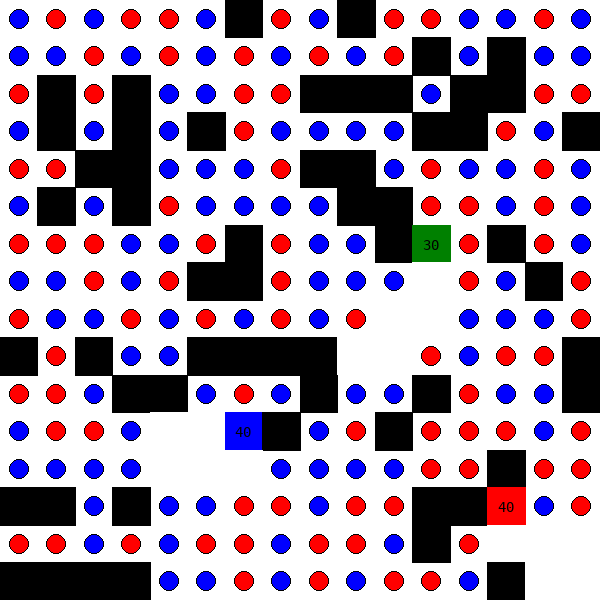

--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.


KeyboardInterrupt: 

In [81]:
eaters = [
    ('blue', simple_move_to_food_agent),
    ('red', simple_move_to_food_agent),
    ('green', simple_move_to_food_agent),
]

runner(eaters)

## Let's write it ourselves!

So far, our agents haven't interacted with the outside world at all. They have only maintained an internal state that we populated manually. 
Using what we know now, we couldn't create a robot that moved through an office building to give a stapler to an employee.
That would require *sensing* walls around it, *moving* using some path finder algorithm, and some *hand-stapler* mechanism that guided the robot arm to place a stapler on a desk.
In Soar, you'd program the logic `if I have a stapler, and <target> is infront of me, hand them the stapler, else move to target` into the agent. 
You *wouldn't* program the actual *moving* or *sensing* however. This is because Soar is a kernel.

#### The kernel

Soar clarifies that it is *not* an all purposed AI machine. Soar is a "kernel". The linux kernel, for example, isn't a full-fledged operating system. It doesn't have a GUI. It doesn't have a text editor you can use to edit files using a mouse and keyboard. It does, however, provide hooks for someone to build these things ontop of it. It manages low level process scheduling, memory management, and security. 

You can think of Soar in a similar fashion. Soar won't give you a nice library for recognizing object from a camera feed or for moving a robot from one location to another with A*. It does, however, give you hooks to send information to the agent (I sense a wall infront of me) for internal planning and reasoning. Then, rules match the new state 

#### IO

Sending information to a Soar agent is done through an `input-link`. Receiving commands from a Soar agent is done through an `output-link`.

In this section, we'll talk about the two phases of the Soar cycle we left out in the last lesson: input and output phase.

TODO picture of the soar cycle


#### Jargon you may come across

`Sensors / perception mechanism` Anything that gives an agent information about the outside world. For example, in the eaters world, we provide the agent with the perception of the food around it. If this was a robotics problem in the real world, our sensor could be a camera. We could perform object recognition from the camera feed then send that information (object name, position, etc) to the Soar agent.

`Actuators` How agents perform actions to modify the world around them.

### Output Link

Let's begin by writing an agent that just moves in one direction. 

We can accomplish this task with two rules: `propose*move-north`, `apply*move-north`.

```
propose*move-north
If I exist, 
then propose the move-north operator.

apply*move-north
If the move-north operator is selected, 
then generate an output command to move north.
```

Soar agents have an object in WM called `io`. 
This `io` object has two children, `input-link` and `output-link`.
We can add to the `output-link` as a way of creating commands.
In this case, our command is `move`. 
Our `move` can store information itself, like the speed at which we want to move, or direction.

In `apply*move-north`, we want to create this `move` object on the `output-link` with the `direction` as `north`.

![Output link](./img/3_output-link-north.png)

#### Exercise

Try writing the above two rules to propose and apply the `move-north` operator.

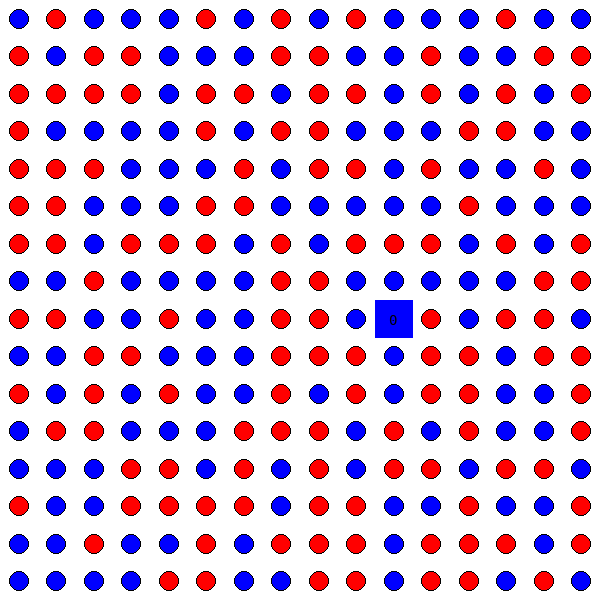

--------- SOURCING PRODUCTIONS ------------
Expected ( to begin condition element
(Ignoring production propose*move-north)
Production addition failed.
	/tmp/agent_blue.soar:2Total: 0 productions sourced.


KeyboardInterrupt: 

In [84]:
my_move_north_operators = """
sp {propose*move-north 
    # Code here
}

sp {apply*move-north
    # Code here
}
"""

eaters = [('blue', my_move_north_operators)]
runner(eaters, total_ticks=4, world_type='all food')

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

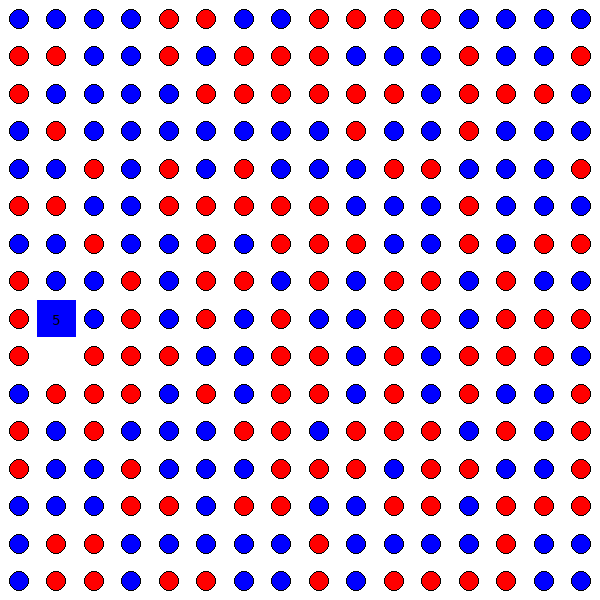

--------- SOURCING PRODUCTIONS ------------
Total: 2 productions sourced.


In [85]:
my_move_north_operators = """
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>) 
    (<io> ^output-link <out>)
    (<o> ^name move-north) 
-->
    (<out> ^move <move>) 
    (<move> ^direction north)}
"""

eaters = [('blue', my_move_north_operators)]
runner(eaters, total_ticks=4, world_type='all food')

The world class consists of

The Eater class
    TODO maybe should refactor this to have the actuator/perception?

The connector class has two new things